In [1]:
# -*- coding: utf-8 -*-
#  File: OTUS_ADV_HW2.ipynb
#  Project: 'OTUS Homework #1'
#  Created by Gennady Matveev (gm@og.ly) on 02-01-2022.

# **$Homework$** **$2$**  

Goals:   
- Create FastAPI classification model application
- Deploy it in docker
- Test get requests by sending X features vector 
- Receive target y response

Means:  
- All meaningful programming will be done in ATOM  
    https://tvdboom.github.io/ATOM/about/

Dataset:
- Heart Disease UCI  
https://www.kaggle.com/ronitf/heart-disease-uci

Abbreviations:
- EDA: exploratory data analysis
- BO: bayesian optimization
- FE: feature engineering
- DFS: deep feature synthesis
- H/P: hyperparameters

### Google colab specific part

Typical runtime on GPU-enabled Colab with ncalls = 256, n_initpoints = 16 BO parameters is around 10 minutes and will increase linearly should you decide to play with them.


In [2]:
# !pip install -r '/content/drive/MyDrive/OTUS_HW1/requirements.txt'

### Import libraries and setup notebook

In [3]:
import pandas as pd
import numpy as np
from atom import ATOMClassifier, ATOMLoader
from sklearn.preprocessing import StandardScaler
from skopt.space.space import Real, Integer
from scipy.io import arff
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML
import warnings
import sys
#sys.path.append('/content/drive/MyDrive/OTUS_HW1/src') #<--- COLAB
sys.path.append('../src/')

from utilities import *

#### Miscellaneius settings 

In [4]:
%matplotlib inline
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'
# plt.rcParams['figure.figsize']=(10,5)
sns.set(rc = {'figure.figsize':(8,5)})
warnings.filterwarnings("ignore")
pd.options.display.precision = 4

#### ML parameters

In [5]:
random_state = 17
njobs = 1 # Try more on Colab
models = ["CATB", "XGB", "RF"] 
metric = ["AUC", "F1", "BA", "AP"]

#### Parameters of BO

In [6]:
ncalls = 1024 #256
n_initpoints = 128 # 16

#### Parameters of DFS and RFECV

In [7]:
n_features_dfs = 64
n_features_rfecv = 32

### Load data

In [8]:
url = 'https://drive.google.com/uc?export=download&id=1wY3r2MwQoa-jiyzRoEM_eF_EU11vrCs0'
df = pd.read_csv(url, compression='zip', encoding='utf8')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


####  Split target from features

In [9]:
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

### EDA

#### Basic

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.3663,9.0821,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.6832,0.4660,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.9670,1.0321,0.0,0.0,1.0,2.0,3.0
trestbps,303.0,131.6238,17.5381,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.2640,51.8308,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.1485,0.3562,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.5281,0.5259,0.0,0.0,1.0,1.0,2.0
thalach,303.0,149.6469,22.9052,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.3267,0.4698,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.0396,1.1611,0.0,0.0,0.8,1.6,6.2


#### Target values distribution

Target distribution by classes:


1    54.5 %
0    45.5 %
Name: target, dtype: object

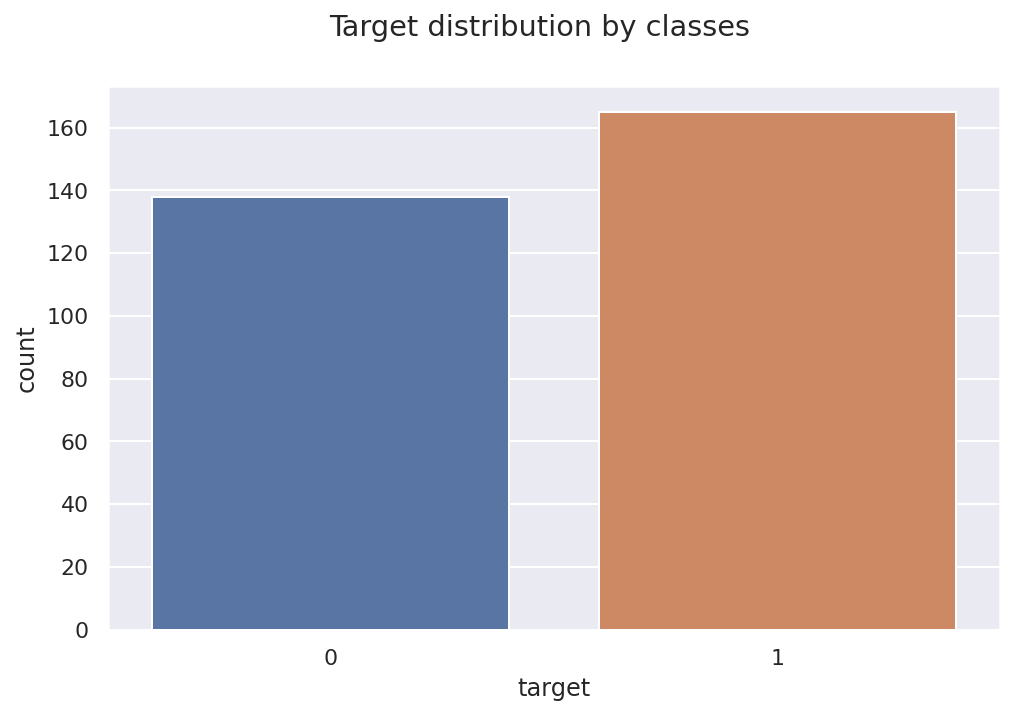

In [12]:
sns.countplot(df['target'], data=df)
plt.suptitle('Target distribution by classes')

print(f'Target distribution by classes:')
df["target"].value_counts(
    normalize=True).apply(lambda x: f'{x*100:.1f} %')

#### Run profile report on the dataset

In [13]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Pipeline

In [14]:
atom = ATOMClassifier(X, y, n_jobs=njobs, verbose=2, warnings=False, random_state=random_state)
atom.clean()
atom.encode()
atom.add(StandardScaler())

<< ================== ATOM ================== >>
Algorithm task: binary classification.

Dataset stats ==================== >>
Shape: (303, 14)
Scaled: False
Outlier values: 16 (0.5%)
Duplicate samples: 1 (0.3%)
-------------------------------------
Train set size: 243
Test set size: 60
-------------------------------------
|    |     dataset |       train |        test |
| -- | ----------- | ----------- | ----------- |
| 0  |   138 (1.0) |   115 (1.0) |    23 (1.0) |
| 1  |   165 (1.2) |   128 (1.1) |    37 (1.6) |

Applying data cleaning...
Fitting Encoder...
Encoding categorical columns...
Fitting StandardScaler...
Applying StandardScaler to the dataset...


### Feature engineering 

#### Run DFS

In [15]:
atom.verbose = 2
atom.feature_generation("dfs", 
                        n_features=n_features_dfs, 
                        operators=["add", "sub", "mul", "div"])

Fitting FeatureGenerator...
Creating new features...
 --> 77 new features were added to the dataset.


#### Make feature selection: check for multicollinearity and use RFECV to reduce their number

In [16]:
atom.feature_selection(  
                        strategy="RFECV",
                        solver="RF",
                        n_features=n_features_rfecv,
                        scoring="logloss",
                        max_correlation=0.98,
                        n_jobs=njobs
)

Fitting FeatureSelector...
Performing feature selection ...
 --> The RFECV selected 39 features from the dataset.
   >>> Dropping feature age (rank 20).
   >>> Dropping feature age * cp (rank 3).
   >>> Dropping feature sex (rank 34).
   >>> Dropping feature cp + sex (rank 19).
   >>> Dropping feature cp - slope (rank 13).
   >>> Dropping feature trestbps / exang (rank 18).
   >>> Dropping feature trestbps / restecg (rank 5).
   >>> Dropping feature chol (rank 26).
   >>> Dropping feature chol * thal (rank 11).
   >>> Dropping feature chol + restecg (rank 27).
   >>> Dropping feature chol - trestbps (rank 16).
   >>> Dropping feature chol / fbs (rank 22).
   >>> Dropping feature chol / restecg (rank 25).
   >>> Dropping feature fbs (rank 39).
   >>> Dropping feature fbs * sex (rank 36).
   >>> Dropping feature fbs * thal (rank 32).
   >>> Dropping feature fbs + thal (rank 2).
   >>> Dropping feature fbs / trestbps (rank 7).
   >>> Dropping feature restecg (rank 38).
   >>> Dropping fea

#### Rescale again, this time - new features

In [17]:
atom.add(StandardScaler())

Fitting StandardScaler...
Applying StandardScaler to the dataset...


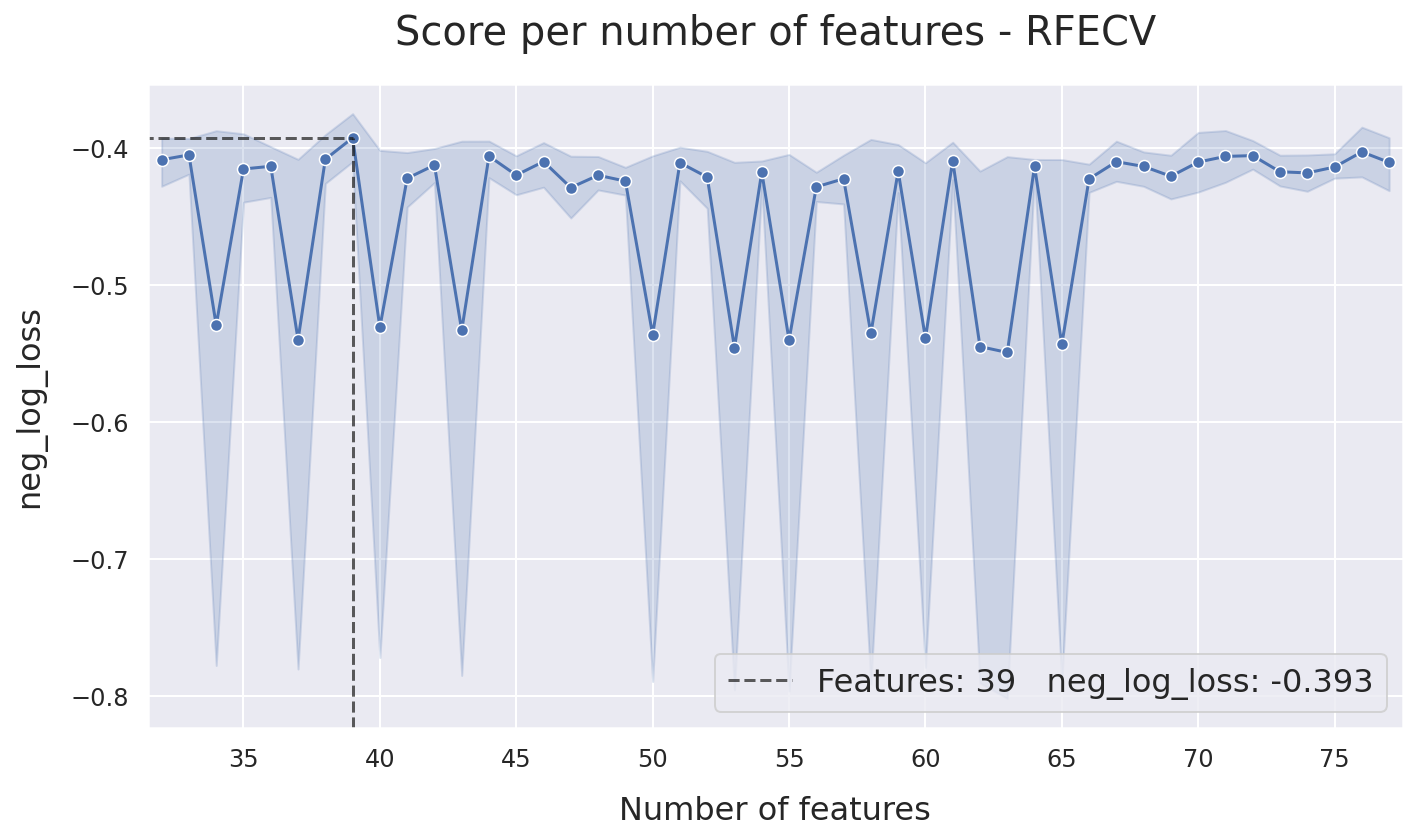

In [18]:
atom.plot_rfecv(title='Score per number of features - RFECV')

Dataset with new features

In [19]:
atom.X

,age * thal,age + chol,age - chol,age - cp,age - sex,age - trestbps,age / oldpeak,sex + trestbps,cp,cp * thalach,...,ca + oldpeak,ca - chol,ca - cp,ca - exang,ca - slope,thal,thal - thalach,thal - trestbps,thal / age,thal / thalach
0,-0.5019,1.5394,-0.6816,1.1492,1.5083,0.6825,-0.0491,-1.1083,-0.9353,-1.2067,...,-1.0714,-1.7178,0.1328,-0.0083,-1.1949,-0.5081,-0.9293,-0.3369,-0.1003,-0.1115
1,1.0125,1.0080,0.1436,0.5828,0.1319,1.2700,0.4531,0.0235,0.0117,-0.3662,...,0.2892,-0.3425,0.1349,0.7066,0.5449,1.0749,2.1170,1.2761,0.1750,-0.1047
2,0.7353,0.2338,0.7329,1.0729,-0.0196,1.2290,0.3464,-0.1035,-0.9353,-0.8081,...,0.8964,1.0605,1.3698,-0.1649,0.0983,1.0749,0.4149,1.4070,0.2372,0.1940
3,0.7353,0.5790,0.3120,1.0729,1.4326,-0.3979,0.0974,-0.2616,-0.9353,-0.6753,...,1.5422,0.6710,1.3698,1.4215,1.1915,1.0749,0.5045,-0.0331,0.2372,0.2906
4,0.0424,-0.2900,0.4849,0.6913,-0.3981,-0.3770,0.0423,0.8701,-0.9353,1.3618,...,1.9422,-0.1456,0.1328,-1.5946,0.9916,1.0749,1.8781,0.4033,1.8614,-0.1163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,-0.3054,1.1856,-0.7823,0.2775,1.2812,0.1035,-0.0095,-0.8543,0.0117,-0.3391,...,0.1430,-0.1777,0.7534,1.4215,0.0983,-0.5081,-0.4216,-0.5988,-0.1780,-0.5240
299,2.1213,1.4418,1.0333,0.5507,0.7375,0.0533,0.1710,1.7167,0.9587,-2.0400,...,1.0964,-0.1756,-0.4814,-0.8797,0.5449,1.0749,1.8483,-0.4695,0.0843,-0.1180
300,-0.8950,0.6566,1.4587,1.6071,1.9626,2.4323,-0.1895,-2.1242,-0.9353,-0.0110,...,0.3045,1.1579,1.3698,1.4215,0.0983,-0.5081,-0.1230,0.7104,-0.0547,0.1139
301,-0.3709,0.3954,0.3586,0.9966,1.3569,-1.6756,-0.0227,0.7543,-0.9353,-0.0553,...,-1.0714,-0.5908,0.1328,-1.5946,-0.1017,-0.5081,-0.1529,-2.2571,-0.1412,0.1392


### Run BO with models

In [ ]:
# atom.run(models, metric=metric, n_calls=ncalls, n_initial_points=n_initpoints, n_jobs=njobs)
atom.run(
    models=models,
    n_calls=ncalls, metric=metric,
    n_initial_points=n_initpoints, n_jobs=njobs,
    est_params={
        "CATB": {"task_type": "GPU"},
        "XGB": {"tree_method": "gpu_hist"}},
    bo_params={
        "dimensions": {
            "CatB": [
                Integer(50, 400, name="n_estimators"),
                Integer(2, 4, name="max_depth"),
                Real(0.01, 0.1, "log-uniform", name="learning_rate"),
                Real(0.01, 0.1, "log-uniform", name="reg_lambda")
            ],
             "XGB": [
                Integer(50, 400, name="n_estimators"),
                Integer(2, 4, name="max_depth"),
                Real(0.01, 0.1, "log-uniform", name="learning_rate"),
            ], 
            "RF": [
                Integer(50, 400, name="n_estimators"),
                Integer(2, 4, name="max_depth"),
                Integer(2, 8, name="min_samples_split"),
            ],
        }, 
        "base_estimator": "RF", "max_time": 1000000,
    },
    n_bootstrap=5, verbose=1
)


Training ========================= >>
Models: CatB, XGB, RF
Metric: roc_auc, f1, balanced_accuracy, average_precision


Running BO for CatBoost...


Iteration 150:  15%|██████▋                                       | 149/1024 [08:20<42:24,  2.91s/it]

In [ ]:
atom.plot_bo(figsize=(8,5))

In [ ]:
atom.branch.status()

### Stack all models: results

In [ ]:
# atom.stacking(name="Stack") #, models=models
atom.stacking()#models=models, final_estimator="LDA")#, cv=5) # name="Stack",
atom.plot_results()

In [ ]:
atom.plot_confusion_matrix(models.append("Stack"), title=f'Confusion matrix for Stack', figsize=(8,5))
# atom.plot_results(title='Results after feature selection')


In [ ]:
nice_metric_table(atom.results, metric=metric).style.highlight_max(props='color:orange', axis=0)

### Final model

In [ ]:
atom.plot_pipeline()

In [ ]:
atom.branch.status()
# pl = atom.export_pipeline(model="Stack1")
# print(pl)

### Save the final model

In [ ]:
# Use save_data=False to save the instance without the data

atom.save("atom")#, save_data=False)

In [ ]:
# Load the instance again with ATOMLoader
# No need to store the transformed data, providing the original dataset to
# the loader automatically transforms it through all the steps in the pipeline

# atom_2 = ATOMLoader("atom", verbose=2)

In [ ]:
# with atom.canvas(2, 2, title="Models evaluation"):
#     model_list = models[:2]
#     for m in model_list:
#         atom.plot_evals(m, title=f"{m}", figsize=(8,5))
# # atom.plot_evals("CATB", title="CatBoost evaluation", figsize=(8,5))